In [1]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp, Statevector
from VQE_CVaR import partition_N
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit

from math import cos, sin, cosh, sinh, atan, exp, pi
from scipy.optimize import minimize

import sys

import copy
import pickle

from qubo_hamiltonian import *

import itertools

import networkx as nx
from networkx import random_graphs

import matplotlib.pyplot as plt

In [2]:
def partition_N(N:int):
    '''do the partition of a complete graph with N vertex, to find the optimal orders for edges to run circuit in parallel
    Args:
        N: number of qubits
    Return:
        pairs_all: list of qubit index pairs (edges) in a order to parallel the circuit
    '''
    indexs = range(N)
    pairs_all = []  

    ## swap indexes of even layer [0,1,2,3,4] -> [1,0,3,2,4]
    swap_even = [i + pow(-1, i) for i in range(N - (N%2))]  
    if (N%2) == 1:
        swap_even.append(N-1)
    ## swap indexes of even layer [0,1,2,3,4] -> [0,2,1,4,3]
    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i+1) for i in range(1,N-(N+1)%2)])
    if (N%2) == 0:
        swap_odd.append(N-1)
    
    ## qubit pairs need to be implemented in layer 0
    pairs_even = [(i, i+1) for i in range(0, N-1, 2)]  
    pairs_all.append(pairs_even)
    indexs = np.array(indexs)[swap_even]   ### indexs after swap even

    for i in range(1, N):
        if (i%2)==1: ## odd layer
            pair_odd = [(indexs[i], indexs[i+1]) for i in range(1, N-1, 2)]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]   ### indexs after swap odd

        elif (i%2)==0: ## even layer
            pair_even = [(indexs[i], indexs[i+1]) for i in range(0, N-1, 2)]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]   ### indexs after swap even

    return pairs_all

def find_light_cone(pairs):
    lightcone_dict = {}
    for index, list in enumerate(pairs):
        for pair in list:
            qi, qj = pair
            relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
            if index > 0:
                for pair_layerm1 in pairs[index-1]: ## qubit pairs in the previous layer
                    if (qi in pair_layerm1) or (qj in pair_layerm1):
                        relevent_pairs.append(pair_layerm1)
            lightcone_dict[pair] = relevent_pairs
    return lightcone_dict

def find_light_cone2(edges_columns, pair_now, lnow, L):
    """find the pairs in lightcone including previous L layers for a specific qubit pair at layer lnow """
    lightcone = []
    qubit_list = list(pair_now) ## qubit index included, which is used to find the pair in lightcone in previous layer
    if L == 0:
        lightcone.append(pair_now)
    else:
        for index in range(lnow-1, max(0, lnow-L)-1, -1):
            pair_list = edges_columns[index]
            for pair in pair_list:
                if pair[0] in qubit_list or pair[1] in qubit_list:
                    lightcone.append(pair)
                    qubit_list.extend(pair)
        lightcone.append(pair_now)
    return lightcone

In [3]:
def circuit_update_zz(Edge,State, Tauc, N):
    i = min(Edge)
    j = max(Edge)

    zzop = SparsePauliOp.from_sparse_list([('ZZ', [j, i], -sinh(Tauc) )], N)
    zzop += SparsePauliOp.from_list([("I"*N, cosh(Tauc))])
    
    State = State.evolve(zzop)

    # Normalize the state vector manually
    norm = np.linalg.norm(State.data)
    State = State / norm

    # Print the normalized state vector
    # print("Normalized state:", State)

    return State

def circuit_update_theta(Edge, State, paras, N):
    
    j = min(Edge)    #I SWAPPED i AND j TO MATCH WITH YAHUI CIRCUIT
    i = max(Edge)

    zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]/2))], N)
    zyop += SparsePauliOp.from_list([("I"*N, cos(paras[0]/2))])

    yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]/2))], N)
    yzop += SparsePauliOp.from_list([("I"*N, cos(paras[1]/2))])

    op = zyop.compose(yzop)
    
    State = State.evolve(op)

    # print('states2', State)

    return State

def ITE(N:int, edge_coeff_dict:dict, tau:float, eigen_list:np.array):
    
    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
        
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    ## Z term 
    for i in range(N):
        #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)
            
    ## ZZ term 
    state = Statevector(circ)
    for edge, coeff in edge_coeff_dict.items():
        if len(edge) == 2:
            tauc = tau * coeff
            state = circuit_update_zz(edge, state, tauc, N)

    state = np.array(state)
    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss
    return exp_poss_dict, state

In [4]:
def square_modulus_cost_light_cone(Paras : list, *args):

    # para_init = np.zeros((len(lightcone_dict[edge]) + 1, 2))

    Edge_list = args[0]
    State = args[1]
    Tauc = args[2]
    Updated_state = args[3]
    N = args[4]

    State_zz = circuit_update_zz(Edge_list[-1], Updated_state, Tauc, N)
    
    for index, edge in enumerate(Edge_list):
        Parameters = [Paras[2*index], Paras[2*index + 1]]
        State = circuit_update_theta(edge,State, Parameters, N)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus

In [5]:
def square_modulus_cost(Paras : list, *args):

    '''Questa funzione non serve realmente dato che basta chiamare quella di prima'''
    
    Edge = args[0]
    State = args[1]
    Tauc = args[2]
    N = args[3]

    State_zz = circuit_update_zz(Edge,State, Tauc, N)
    State_theta = circuit_update_theta(Edge,State, Paras, N)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State_theta)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus


In [6]:
def warm_start_parameters_lightcone(N : int, tau:float, edge_coeff_dict : dict, edges_columns :list,  eigen_list:list, lightcone_dict: dict):    

    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
    
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    # Z term
    for i in range(N):

        #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)
        
    ## ZZ term 
    state = Statevector(circ)
    #updated_state = state 
    #updated_state = copy.deepcopy(state)

    # print('state in', state)
    #print('updated_state in', updated_state)

    #print('\nnumber of columns is:', len(edges_columns))

    for column_index, column in enumerate(edges_columns):
        # print('\n##################################################')
        # print('column index', column_index, 'column', column)

        if column_index == 0: 

            first_column_state = state
            #first_column_state = copy.deepcopy(state)

            for edge in column:
                
                if len(lightcone_dict[edge]) != 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()
            
                # print('\nedge', edge)  

                tauc = tau * edge_coeff_dict[edge]

                para_init = [0,0]
                # para_init = [pi/2,pi/2]

                final = minimize(square_modulus_cost,
                                    para_init,
                                    args = (edge, first_column_state, tauc, N),
                                    jac=False,
                                    bounds=None,
                                    #method='L-BFGS-B',
                                    method='SLSQP',
                                    callback=None,
                                    options={'maxiter': 1000})

                para = final.x

                # print('opt paramenters', para)
                # print('final square modulus', final.fun)
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                edge_params_dict[edge] = para
                # print('edge_params_dict:', edge_params_dict)

                # print('old state', state)
                first_column_state = circuit_update_theta(edge, first_column_state, para, N)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT

                # print('first column state - new state', first_column_state)
            
        else:
            
            for edge in column: 
                # if len(lightcone_dict[edge]) == 0:
                #         sys.stderr.write('something is wrong with the lightcones')
                #         sys.exit()

                # print('\nedge', edge)  

                # print('len light cone:', len(lightcone_dict[edge]), ', light cone edges:', lightcone_dict[edge])

                # print('initial state', state)

                updated_state = copy.deepcopy(state)
                #updated_state = state

                #print('state in', state, 'column edge', column, edge)
                #print('updated_state in', updated_state, 'column edge', column, edge)
                
                for old_edge in lightcone_dict[edge]:
                    # print('old_edge', old_edge, 'param', edge_params_dict[old_edge])
                    updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N)    
                
                # print('updated_state', updated_state)

                edge_list = lightcone_dict[edge] + [edge]
                # print('edge list', edge_list)
                
                tauc = tau * edge_coeff_dict[edge]

                para_init = np.zeros(2 + 2*len(lightcone_dict[edge]))
                # para_init = np.zeros(2 + 2*len(lightcone_dict[edge])) + pi/2
                # print('para init', para_init)

                final = minimize(square_modulus_cost_light_cone,
                        para_init,
                        args = (edge_list, state, tauc, updated_state, N),
                        jac=False,
                        bounds=None,
                        #method='L-BFGS-B', 
                        method='SLSQP',
                        callback=None,
                        options={'maxiter': 1000})

                para = final.x
                # print('opt paramenters', para)
                # print('final square modulus', final.fun)
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                para = (np.array(para)).reshape(-1, 2)
                # print('param list reshaped', para)
                for index, edge in enumerate(edge_list):
                    edge_params_dict[edge] = para[index] 
                # print('edge_params_dict', edge_params_dict)
            
            # print('\n######### previous column update ########')
            # print('column index', column_index, 'column', column)
            # print('previous column is:', edges_columns[column_index -1])

            for edge in edges_columns[column_index -1]:
                # print('edge', edge, 'parameter', edge_params_dict[edge])
                state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

            # print('circuit updated ad the previous column i.e. column', column_index -1)
            # print('updated statevector', state)

    # print('\n######### last column update ########')
    # print('last column is:', edges_columns[ -1])

    for edge in edges_columns[ -1]:
        # print('edge', edge, 'parameter', edge_params_dict[edge])
        state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

    # print('circuit updated at the last column i.e.', len(edges_columns) - 1)
    #print('updated statevector', state)

    #generate params_list
    values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
    # Concatenate and flatten all arrays into a single array
    flattened_array = np.concatenate(values_as_arrays)
    # Convert the flattened array to a list if needed
    params_list = flattened_array.tolist()
    # print(' params_list' , params_list )

    state = np.array(state)

    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss

    # return edge_params_dict, params_list, exp_poss_dict
    return edge_params_dict, params_list, exp_poss_dict, state #Changed to see the state overlap

In [7]:
def warm_start_parameters_adaptlightcone(N : int, tau:float, numpara:int, ampth:float, edge_coeff_dict : dict, edges_columns :list,  eigen_list:list, lightcone_dict: dict):
    '''' warm start the parameters for the circuit using the lightcone adaptivly
    Args:
        N: number of qubits
        tau: imaginary time
        numpara: number of parameters for each edge, 2, 4, or 6
        ampth: amplitude threshold, if the amplitude between optimized state and ITE state is larger than this value, the optimization stops; \
               otherwise continue with a larger lightcone including more previous layers
        edge_coeff_dict: coefficients for each edge
        edges_columns: list of edges in each layer
        eigen_list: list of eigenvalues
    Return:
        edge_params_dict: parameters for each edge
        params_list: list of parameters
        exp_poss_dict: probabilities of eigenvalues using warm start circuit
        state: final state vector 
    '''
    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
    
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit
    edge_coeff_dict_ite = {} ## record the edges has been executed, to get the ite state for each step

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    ## Z term 
    for i in range(N):
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)

        edge_coeff_dict_ite[(i,)] = edge_coeff_dict[(i,)]
   
    
    ## ZZ term 
    state = Statevector(circ)
    for column_index, column in enumerate(edges_columns):
        #print('\n### column index', column_index, 'column', column)
        if column_index == 0: 
            first_column_state = copy.deepcopy(state)
            for edge in column:
                if len(lightcone_dict[edge]) != 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()
                edge_coeff_dict_ite[edge] = edge_coeff_dict[edge]
                _, state_ite = ITE(N, edge_coeff_dict_ite, tau, eigen_list)

                tauc = tau * edge_coeff_dict[edge]

                para_init = [0]* numpara
                # para_init = [pi/2]* numpara

                final = minimize(square_modulus_cost_light_cone,
                        para_init,
                        args = ([edge], first_column_state, tauc, first_column_state, N),
                        jac=False,
                        bounds=None,
                        method='SLSQP',
                        #method='L-BFGS-B', 
                        callback=None,
                        options={'maxiter': 1000})
                para = final.x
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                edge_params_dict[edge] = para

                #region check the overlap between the ite state and the optimized state
                state_opt = copy.deepcopy(state)
                for old_edge in edge_coeff_dict_ite.keys():
                    if len(old_edge) == 2:
                        state_opt = circuit_update_theta(old_edge, state_opt, edge_params_dict[old_edge], N)
                state_opt = np.array(state_opt)
                #print('overlap between ite and optimized state: ', state_ite.T.conj() @ state_opt)
                
        else:
            for ei, edge in enumerate(column):  
                #print('\nedge:', edge, ',  coeff:', edge_coeff_dict[edge])
                edge_coeff_dict_ite[edge] = edge_coeff_dict[edge]
                _, state_ite = ITE(N, edge_coeff_dict_ite, tau, eigen_list)
                ## optimize the gate in the lightcone including previous L layers
                for L in range(0, column_index+1):
                    lightcone = find_light_cone2(edges_columns, edge, column_index, L)  ## current edge is included in the lightcone, which is the last element in the list
                    #print('~~L:', L, 'lightcone:', lightcone)

                    updated_state = copy.deepcopy(state)
                    optimized_state = copy.deepcopy(state)

                    para_init = []
                    edge_list = []  ## to save the edges in the lightcone that will be optimized
                    for ci in range(column_index-L):## previours layer before lightcone
                        for old_edge in edges_columns[ci]:
                            updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N)  
                            optimized_state = circuit_update_theta(old_edge, optimized_state, edge_params_dict[old_edge], N)
                    for ci in range(column_index-L, column_index):## layer in lightcone      
                        for old_edge in edges_columns[ci]:
                            if old_edge in lightcone:
                                edge_list.append(old_edge)
                                para_init.extend(list(edge_params_dict[old_edge]))
                                updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N) 
                    
                    tauc = tau * edge_coeff_dict[edge]

                    edge_list = edge_list + [edge]
                    para_init = para_init + [0]*numpara
                    # para_init = para_init + [pi/2]*numpara
                    
                    #print('optimize edge list', edge_list, ',  para_init: ', para_init)
                    final = minimize(square_modulus_cost_light_cone,
                            para_init,
                            args = (edge_list, optimized_state, tauc, updated_state, N),
                            jac=False,
                            bounds=None,
                            method='SLSQP',
                            #method='L-BFGS-B',  
                            callback=None,
                            options={'maxiter': 1000})

                    para = final.x
                    #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                    ## check the overlap between the ite state and the optimized state
                    para = (np.array(para)).reshape(-1, numpara)
                    edge_para_dict = {edge:para[index] for index, edge in enumerate(edge_list)}
                    for ci in range(column_index-L, column_index+1):## layer in lightcone      
                        for old_edge in edges_columns[ci]:
                            if old_edge in edge_coeff_dict_ite.keys():
                                if old_edge in lightcone:
                                    optimized_state = circuit_update_theta(old_edge, optimized_state, edge_para_dict[old_edge], N)
                                else:
                                    optimized_state = circuit_update_theta(old_edge, optimized_state, edge_params_dict[old_edge], N)
                    optimized_state = np.array(optimized_state)
                    #print('overlap between ite and optimized state: ', state_ite.T.conj() @ optimized_state)

                    if final.fun < -ampth:  ##
                        break
                if L>0:
                    print('L',L)

                ## update the parameters for the optimized edge
                for index, edge in enumerate(edge_list):
                    edge_params_dict[edge] = para[index]
                ## check the overlap between the ite state and the optimized state
                state_opt = copy.deepcopy(state)
                for old_edge in edge_coeff_dict_ite.keys():
                    if len(old_edge) == 2:
                        state_opt = circuit_update_theta(old_edge, state_opt, edge_params_dict[old_edge], N)
                state_opt = np.array(state_opt)
                #print('overlap between ite and final optimized state: ', state_ite.T.conj() @ state_opt)
                 
                

    ## get the final state vector
    for ci in range(len(edges_columns)):
        for edge in edges_columns[ ci]:
            state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

    #generate params_list
    values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
    # Concatenate and flatten all arrays into a single array
    flattened_array = np.concatenate(values_as_arrays)
    # Convert the flattened array to a list if needed
    params_list = flattened_array.tolist()
    # print(' params_list' , params_list )

    state = np.array(state)

    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss
    return edge_params_dict, params_list, exp_poss_dict, state

Test code


Try different orderings

In [163]:
def sorted_gates(coefficients, edges, Abs, invert):

    if Abs:
        coefficients = np.abs(coefficients)

    sorted_index = np.argsort(coefficients)

    if invert:
        sorted_index = sorted_index[::-1]

    sorted_edges = [edges[x] for x in sorted_index]

    grouped = []
    group = []

    for t in sorted_edges:
        qi, qj = t
        if any(qi in pair for pair in group) or any(qj in pair for pair in group):
            grouped.append(group)
            group = []
        group.append(t)  
    grouped.append(group)

    if len(list(itertools.chain.from_iterable(grouped))) != len(edges):
        sys.stderr.write('something is wrong with the new columns')
        sys.exit()

    return sorted_edges, grouped 


def sorted_columns(edge_coeff_dict, edges_columns, Abs, invert):
    sum_jcol = []

    if Abs:
        for column in edges_columns:
            abs_sum_j = 0
            for edge in column:
                abs_sum_j += abs(edge_coeff_dict[edge])
            sum_jcol.append(abs_sum_j)

    else:
        for column in edges_columns:
            sum_j = 0 
            for edge in column:
                sum_j += edge_coeff_dict[edge]
            sum_jcol.append(sum_j)

    new_index = np.argsort(sum_jcol)
    
    if invert:
        new_index = new_index[::-1]

    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    return sorted_edge_columns.tolist()


In [170]:
#SORTING THE GATES

# Set the seed
np.random.seed(52)

N = 6
tau = 1
Numpara = 2
ntrials = 50

#Def graph with edges
G = nx.complete_graph(N)
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)

print('\n\n#############################################################################')

ITE_poss = []

# Initialize the dictionary using dictionary comprehension
solution_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }
iteoverlap_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

solution_dict['old']['Random'] = []
solution_dict['lightcone']['Random'] = []
iteoverlap_dict['old']['Random'] = []
iteoverlap_dict['lightcone']['Random'] = []

# Print the resulting dictionary
print(solution_dict['old']['Sort_False_False'])
print(iteoverlap_dict)

# Print the resulting dictionary
print(solution_dict)
print(iteoverlap_dict)

for trial in range(ntrials):
    print(f"\nTrial: {trial}")

    #Set random coefficients and correspoding Hamiltonian
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    #Make edge coeff dictionary
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    ITE_poss.append(list(exp_poss_dict.items())[0][1])
    print('exp_poss_dict', list(exp_poss_dict.items())[0])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    solution_dict['old']['Random'].append(list(exp_poss_dict.items())[0][1])
    iteoverlap_dict['old']['Random'].append(abs(np.dot(state_ite, state_all))**2)
    print('OLD RANDOM: ','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    
    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    solution_dict['lightcone']['Random'].append(list(exp_poss_dict.items())[0][1])
    iteoverlap_dict['lightcone']['Random'].append(abs(np.dot(state_ite, state_all))**2)
    print('LIGHTCONE RANDOM: ','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sort')
    for Abs in [True, False]:
        for invert in [True, False]:
            
            #Sort gates according to J
            sorted_edges, sorted_edge_columns = sorted_gates(coeff_list[N :], pairs_all, Abs, invert)
            sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

            edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
            solution_dict['old'][f'Sort_{Abs}_{invert}'].append(list(exp_poss_dict.items())[0][1])
            iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'].append(abs(np.dot(state_ite, state_all))**2)
            print(f'OLD SORTED {Abs} {invert}:','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)

            edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
            solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(list(exp_poss_dict.items())[0][1])
            iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(abs(np.dot(state_ite, state_all))**2)
            print(f'LIGHTCONE SORTED {Abs} {invert}:','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)


    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive')
    # Ampth = 0.95 
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # oldp.append(list(exp_poss_dict.items())[0][1])
    # oldov.append(abs(np.dot(state_ite, state_all))**2)
    #  print('RANDOM: ','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)

    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # soldp.append(list(exp_poss_dict.items())[0][1])
    # soldov.append(abs(np.dot(state_ite, state_all))**2)
    #print('SORTED :','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)





#############################################################################
[]
{'old': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}, 'lightcone': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}}
{'old': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}, 'lightcone': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}}
{'old': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}, 'lightcone': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}}

Trial: 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-7.169405212179654, 0.9875072263242631)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
OLD RANDOM:  exp_poss_dict (-7.16940521217

In [171]:
print('\n~~~~~~~~RESULTS')

count_larger_sol = 0
count_list_sol = []

count_larger_overlap = 0
count_list_overlap = []

for Abs in [True, False]:
    for invert in [True, False]:

        count_larger_sol = 0
        count_list_sol = []

        count_larger_overlap = 0
        count_list_overlap = []

        print("\n absolute value", Abs, 'inverted sorting', invert)
        for i, (val1, val2) in enumerate(zip(solution_dict['old']['Random'], solution_dict['old'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, overlap {iteoverlap_dict['old']['Random'][i]}, overlap {iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_sol += 1
                count_list_sol.append(i)
        for i, (val1, val2) in enumerate(zip(iteoverlap_dict['old']['Random'], iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, solution { solution_dict['old']['Random'][i]}, solution {solution_dict['old'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_overlap += 1
                count_list_overlap.append(i)

        print(f"\nNumber of values where not sorted is better in solution OLD WAY: {count_larger_sol}", ", ratio: ", count_larger_sol/ntrials)
        print("Before was better for: ", count_list_sol)
        print(f"\nNumber of values where not sorted is better in overlap OLD WAY: {count_larger_overlap}", ", ratio: ", count_larger_overlap/ntrials)
        print("Before was better for: ", count_list_overlap,"\n")

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ LIGHTCONE')
for Abs in [True, False]:
    for invert in [True, False]:

        count_larger_sol = 0
        count_list_sol = []

        count_larger_overlap = 0
        count_list_overlap = []

        print("\n absolute value", Abs, 'inverted sorting', invert)
        for i, (val1, val2) in enumerate(zip(solution_dict['lightcone']['Random'], solution_dict['lightcone'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, overlap {iteoverlap_dict['lightcone']['Random'][i]}, overlap {iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_sol += 1
                count_list_sol.append(i)
        for i, (val1, val2) in enumerate(zip(iteoverlap_dict['lightcone']['Random'], iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, solution { solution_dict['lightcone']['Random'][i]}, solution {solution_dict['lightcone'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_overlap += 1
                count_list_overlap.append(i)

        print(f"\nNumber of values where not sorted is better in solution OLD WAY: {count_larger_sol}", ", ratio: ", count_larger_sol/ntrials)
        print("Before was better for: ", count_list_sol)
        print(f"\nNumber of values where not sorted is better in overlap OLD WAY: {count_larger_overlap}", ", ratio: ", count_larger_overlap/ntrials)
        print("Before was better for: ", count_list_overlap,"\n")

######################################################
#Try to sort adaptively using overlap with ITE - old style 

keys = [] 
for i in range(ntrials):
    current_value = iteoverlap_dict['old']['Random'][i]
    new_key = 'Random'

    for Abs in [True, False]:
        for invert in [True, False]: 
            if iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'][i] > current_value:
                current_value = iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'][i]
                new_key = f'Sort_{Abs}_{invert}'
    keys.append(new_key)
    print('\n initial',  iteoverlap_dict['old']['Random'][i], 'final', current_value)
    print('solution initial',  solution_dict['old']['Random'][i], 'final', solution_dict['old'][new_key][i])

print('\n')
print(solution_dict['old']['Random'], ' Without sorting')
best_sorted = [ solution_dict['old'].get(key)[i] for i,key in enumerate(keys) ]
print(best_sorted, 'Sorting')


######################################################
#Try to sort adaptively using overlap with ITE - lightcone 

light_keys = [] 
for i in range(ntrials):
    current_value = iteoverlap_dict['lightcone']['Random'][i]
    new_key = 'Random'

    for Abs in [True, False]:
        for invert in [True, False]: 
            if iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'][i] > current_value:
                current_value = iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'][i]
                new_key = f'Sort_{Abs}_{invert}'
    light_keys.append(new_key)
    print('\n initial',  iteoverlap_dict['lightcone']['Random'][i], 'final', current_value)
    print('solution initial',  solution_dict['lightcone']['Random'][i], 'final', solution_dict['lightcone'][new_key][i])

print('\n')
print(solution_dict['old']['Random'], ' Without sorting')
print(best_sorted, 'Sorting')
print(solution_dict['lightcone']['Random'], ' Lightcone Without sorting')
light_best_sorted = [ solution_dict['lightcone'].get(key)[i] for i,key in enumerate(light_keys) ]
print(light_best_sorted, 'Lightcone Sorting')
print(keys)
print(light_keys)

r_vs_sorted = 0
r_vs_sorted_light = 0 
old_vs_light = 0 
for i in range(ntrials):
    if best_sorted[i] > solution_dict['old']['Random'][i]:
        r_vs_sorted += 1
    if light_best_sorted[i] > solution_dict['lightcone']['Random'][i]:
        r_vs_sorted_light += 1
    if best_sorted[i] > light_best_sorted[i]:
        old_vs_light += 1
print(f"Old - Adaptive sorting imporoved {r_vs_sorted} time, ratio {r_vs_sorted/ntrials}")
print(f"Lightcone - Adaptive sorting imporoved {r_vs_sorted_light} time, ratio {r_vs_sorted_light/ntrials}")
print(f"Old better than lightcone {old_vs_light} times, ratio {old_vs_light/ntrials}")
if old_vs_light/ntrials >= 0.5:
    print("old style sorted is still better")
else:
    print("lightcone improved is better")


~~~~~~~~RESULTS

 absolute value True inverted sorting True
Index 0: p = 0.8231301792788407, sorted p = 0.7824601367920945, overlap 0.858696488596648, overlap 0.8201543139641849
Index 2: p = 0.7693291867738611, sorted p = 0.4613984211537136, overlap 0.8435102636406155, overlap 0.5627491733067878
Index 5: p = 0.006566337306659554, sorted p = 0.0013730695280019566, overlap 0.2703152750422818, overlap 0.22609184505858912
Index 8: p = 0.001993141021676945, sorted p = 0.00012810277012896727, overlap 0.10060602256223247, overlap 0.16847359340448156
Index 10: p = 0.7842106450279099, sorted p = 0.5147259402859687, overlap 0.7951126594664831, overlap 0.940380819490201
Index 11: p = 0.5734870394021098, sorted p = 0.033429725158253126, overlap 0.7611369417658895, overlap 0.06722021378552735
Index 13: p = 0.30967567576419663, sorted p = 0.19661124009114644, overlap 0.8301887855883258, overlap 0.7921175097857118
Index 14: p = 0.7512028378832377, sorted p = 0.6636508807640682, overlap 0.59845258978

In [172]:
#SORTING THE COLUMNS

# Set the seed
np.random.seed(52)

N = 6
tau = 1
Numpara = 2
ntrials = 50

#Def graph with edges
G = nx.complete_graph(N)
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)

print('\n\n#############################################################################')

ITE_poss = []

# Initialize the dictionary using dictionary comprehension
solution_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }
iteoverlap_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

solution_dict['old']['Random'] = []
solution_dict['lightcone']['Random'] = []
iteoverlap_dict['old']['Random'] = []
iteoverlap_dict['lightcone']['Random'] = []

# Print the resulting dictionary
print(solution_dict['old']['Sort_False_False'])
print(iteoverlap_dict)

# Print the resulting dictionary
print(solution_dict)
print(iteoverlap_dict)

for trial in range(ntrials):
    print(f"\nTrial: {trial}")

    #Set random coefficients and correspoding Hamiltonian
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    #Make edge coeff dictionary
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    ITE_poss.append(list(exp_poss_dict.items())[0][1])
    print('exp_poss_dict', list(exp_poss_dict.items())[0])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    solution_dict['old']['Random'].append(list(exp_poss_dict.items())[0][1])
    iteoverlap_dict['old']['Random'].append(abs(np.dot(state_ite, state_all))**2)
    print('OLD RANDOM: ','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    
    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    solution_dict['lightcone']['Random'].append(list(exp_poss_dict.items())[0][1])
    iteoverlap_dict['lightcone']['Random'].append(abs(np.dot(state_ite, state_all))**2)
    print('LIGHTCONE RANDOM: ','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sort')
    for Abs in [True, False]:
        for invert in [True, False]:
            
            #Sort gates according to J
            sorted_edge_columns = sorted_columns(edge_coeff_dict, edges_columns, Abs, invert)
            sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

            edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
            solution_dict['old'][f'Sort_{Abs}_{invert}'].append(list(exp_poss_dict.items())[0][1])
            iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'].append(abs(np.dot(state_ite, state_all))**2)
            print(f'OLD SORTED {Abs} {invert}:','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)

            edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
            solution_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(list(exp_poss_dict.items())[0][1])
            iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'].append(abs(np.dot(state_ite, state_all))**2)
            print(f'LIGHTCONE SORTED {Abs} {invert}:','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)


    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive')
    # Ampth = 0.95 
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # oldp.append(list(exp_poss_dict.items())[0][1])
    # oldov.append(abs(np.dot(state_ite, state_all))**2)
    #  print('RANDOM: ','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)

    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # soldp.append(list(exp_poss_dict.items())[0][1])
    # soldov.append(abs(np.dot(state_ite, state_all))**2)
    #print('SORTED :','exp_poss_dict', list(exp_poss_dict.items())[0], ', overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)





#############################################################################
[]
{'old': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}, 'lightcone': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}}
{'old': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}, 'lightcone': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}}
{'old': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}, 'lightcone': {'Sort_True_True': [], 'Sort_True_False': [], 'Sort_False_True': [], 'Sort_False_False': [], 'Random': []}}

Trial: 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-7.169405212179654, 0.9875072263242631)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
OLD RANDOM:  exp_poss_dict (-7.16940521217

In [173]:
print('\n~~~~~~~~RESULTS')

count_larger_sol = 0
count_list_sol = []

count_larger_overlap = 0
count_list_overlap = []

for Abs in [True, False]:
    for invert in [True, False]:

        count_larger_sol = 0
        count_list_sol = []

        count_larger_overlap = 0
        count_list_overlap = []

        print("\n absolute value", Abs, 'inverted sorting', invert)
        for i, (val1, val2) in enumerate(zip(solution_dict['old']['Random'], solution_dict['old'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, overlap {iteoverlap_dict['old']['Random'][i]}, overlap {iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_sol += 1
                count_list_sol.append(i)
        for i, (val1, val2) in enumerate(zip(iteoverlap_dict['old']['Random'], iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, solution { solution_dict['old']['Random'][i]}, solution {solution_dict['old'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_overlap += 1
                count_list_overlap.append(i)

        print(f"\nNumber of values where not sorted is better in solution OLD WAY: {count_larger_sol}", ", ratio: ", count_larger_sol/ntrials)
        print("Before was better for: ", count_list_sol)
        print(f"\nNumber of values where not sorted is better in overlap OLD WAY: {count_larger_overlap}", ", ratio: ", count_larger_overlap/ntrials)
        print("Before was better for: ", count_list_overlap,"\n")

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ LIGHTCONE')
for Abs in [True, False]:
    for invert in [True, False]:

        count_larger_sol = 0
        count_list_sol = []

        count_larger_overlap = 0
        count_list_overlap = []

        print("\n absolute value", Abs, 'inverted sorting', invert)
        for i, (val1, val2) in enumerate(zip(solution_dict['lightcone']['Random'], solution_dict['lightcone'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, overlap {iteoverlap_dict['lightcone']['Random'][i]}, overlap {iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_sol += 1
                count_list_sol.append(i)
        for i, (val1, val2) in enumerate(zip(iteoverlap_dict['lightcone']['Random'], iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'])):
            if val1 > val2:
                print(f"Index {i}: p = {val1}, sorted p = {val2}, solution { solution_dict['lightcone']['Random'][i]}, solution {solution_dict['lightcone'][f'Sort_{Abs}_{invert}'][i]}")
                count_larger_overlap += 1
                count_list_overlap.append(i)

        print(f"\nNumber of values where not sorted is better in solution OLD WAY: {count_larger_sol}", ", ratio: ", count_larger_sol/ntrials)
        print("Before was better for: ", count_list_sol)
        print(f"\nNumber of values where not sorted is better in overlap OLD WAY: {count_larger_overlap}", ", ratio: ", count_larger_overlap/ntrials)
        print("Before was better for: ", count_list_overlap,"\n")

######################################################
#Try to sort adaptively using overlap with ITE - old style 

keys = [] 
for i in range(ntrials):
    current_value = iteoverlap_dict['old']['Random'][i]
    new_key = 'Random'

    for Abs in [True, False]:
        for invert in [True, False]: 
            if iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'][i] > current_value:
                current_value = iteoverlap_dict['old'][f'Sort_{Abs}_{invert}'][i]
                new_key = f'Sort_{Abs}_{invert}'
    keys.append(new_key)
    print('\n initial',  iteoverlap_dict['old']['Random'][i], 'final', current_value)
    print('solution initial',  solution_dict['old']['Random'][i], 'final', solution_dict['old'][new_key][i])

print('\n')
print(solution_dict['old']['Random'], ' Without sorting')
best_sorted = [ solution_dict['old'].get(key)[i] for i,key in enumerate(keys) ]
print(best_sorted, 'Sorting')


######################################################
#Try to sort adaptively using overlap with ITE - lightcone 

light_keys = [] 
for i in range(ntrials):
    current_value = iteoverlap_dict['lightcone']['Random'][i]
    new_key = 'Random'

    for Abs in [True, False]:
        for invert in [True, False]: 
            if iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'][i] > current_value:
                current_value = iteoverlap_dict['lightcone'][f'Sort_{Abs}_{invert}'][i]
                new_key = f'Sort_{Abs}_{invert}'
    light_keys.append(new_key)
    print('\n initial',  iteoverlap_dict['lightcone']['Random'][i], 'final', current_value)
    print('solution initial',  solution_dict['lightcone']['Random'][i], 'final', solution_dict['lightcone'][new_key][i])

print('\n')
print(solution_dict['old']['Random'], ' Without sorting')
print(best_sorted, 'Sorting')
print(solution_dict['lightcone']['Random'], ' Lightcone Without sorting')
light_best_sorted = [ solution_dict['lightcone'].get(key)[i] for i,key in enumerate(light_keys) ]
print(light_best_sorted, 'Lightcone Sorting')
print(keys)
print(light_keys)

r_vs_sorted = 0
r_vs_sorted_light = 0 
old_vs_light = 0 
for i in range(ntrials):
    if best_sorted[i] > solution_dict['old']['Random'][i]:
        r_vs_sorted += 1
    if light_best_sorted[i] > solution_dict['lightcone']['Random'][i]:
        r_vs_sorted_light += 1
    if best_sorted[i] > light_best_sorted[i]:
        old_vs_light += 1
print(f"Old - Adaptive sorting imporoved {r_vs_sorted} time, ratio {r_vs_sorted/ntrials}")
print(f"Lightcone - Adaptive sorting imporoved {r_vs_sorted_light} time, ratio {r_vs_sorted_light/ntrials}")
print(f"Old better than lightcone {old_vs_light} times, ratio {old_vs_light/ntrials}")
if old_vs_light/ntrials >= 0.5:
    print("old style sorted is still better")
else:
    print("lightcone improved is better")


~~~~~~~~RESULTS

 absolute value True inverted sorting True
Index 0: p = 0.8231301792788407, sorted p = 0.7691750418912702, overlap 0.858696488596648, overlap 0.809153762580151
Index 3: p = 0.4251296173105265, sorted p = 0.0029210688158822318, overlap 0.5555436354918699, overlap 0.0538511098894416
Index 5: p = 0.006566337306659554, sorted p = 0.004266995734128219, overlap 0.2703152750422818, overlap 0.1831910425445444
Index 6: p = 0.5903054908380396, sorted p = 0.5549107218785783, overlap 0.8088250642304388, overlap 0.7946348987939397
Index 7: p = 0.7629011751296113, sorted p = 0.5919710472473096, overlap 0.9103269487840925, overlap 0.8502157753113199
Index 10: p = 0.7842106450279099, sorted p = 0.781873085512166, overlap 0.7951126594664831, overlap 0.8059576711989724
Index 14: p = 0.7512028378832377, sorted p = 0.674088646058614, overlap 0.5984525897804841, overlap 0.7973034073953407
Index 15: p = 0.4849045161043382, sorted p = 0.4598488620461493, overlap 0.676911397058317, overlap 0

OLD STUFF!!!!!!!!!!!!!!

In [174]:

# Define color codes
RESET = '\033[0m'   # Reset to default color
RED = '\033[91m'    # Red text
# GREEN = '\033[92m'  # Green text
# BLUE = '\033[94m'   # Blue text




#############################################################################
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
[(0, 1), (2, 3), (4, 5), (0, 3), (2, 5), (1, 3), (0, 5), (2, 4), (1, 5),

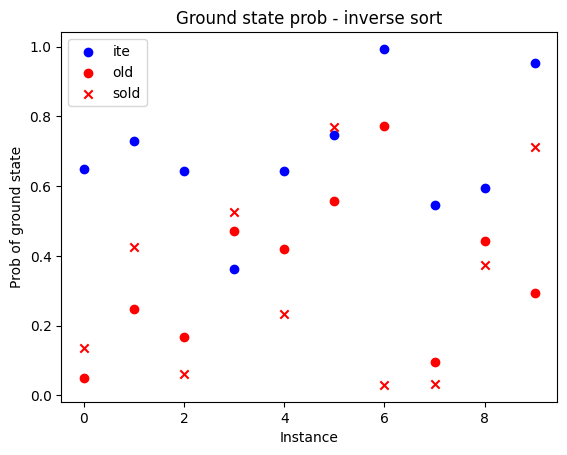

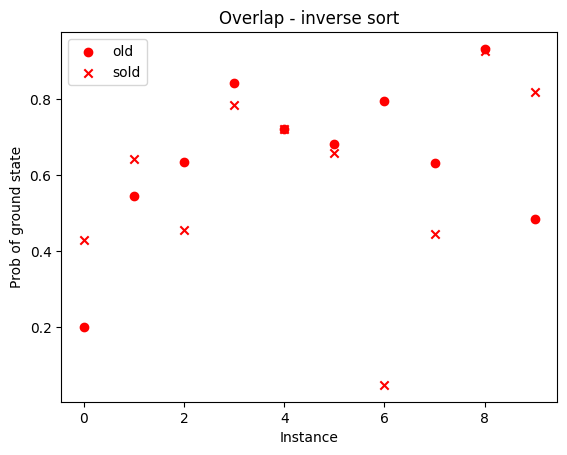

In [175]:
# NEW COLUMNS  GROUPING FOR SORTING   abs

# Set the seed
np.random.seed(420)

N = 6
tau = 1
Numpara = 2
ntrials = 10
G = nx.complete_graph(N)

print('\n\n#############################################################################')

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    abss = np.abs(coeff_list[N:])
    sorted_index = np.argsort(abss)
    # sorted_index = np.argsort(coeff_list[N:])[::-1]

    sorted_pairs_all = [pairs_all[x] for x in sorted_index]

    # print(edge_list)
    print(pairs_all)
    print('sorted_pairs_all', sorted_pairs_all) 

    grouped = []
    group = []

    for t in sorted_pairs_all:
        qi, qj = t
        if any(qi in pair for pair in group) or any(qj in pair for pair in group):
            grouped.append(group)
            group = []
        group.append(t)  
    grouped.append(group)

    if len(list(itertools.chain.from_iterable(grouped))) != len(pairs_all):
        sys.stderr.write('something is wrong with the new columns')
        sys.exit()

    print('\n columns', grouped)
    grouped_lightcone_dict = find_light_cone(grouped)
    print('\n lightcone',grouped_lightcone_dict)

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(grouped):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()




#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
[(0, 1), (2, 3), (4, 5), (0, 3), (2, 5), (1, 3), (0, 5), (2, 4), 

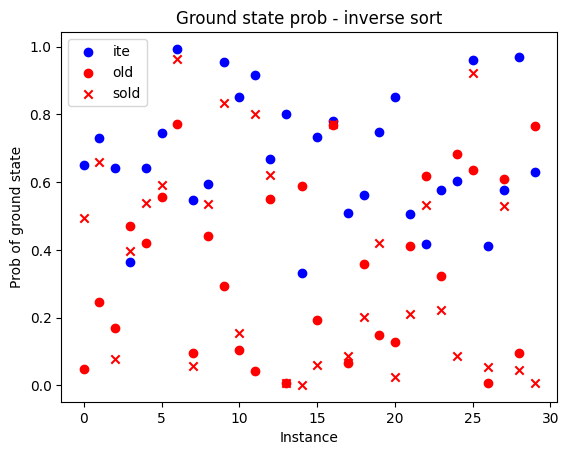

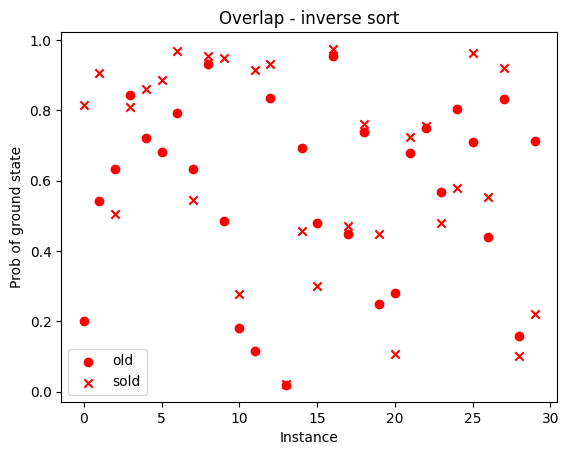

In [176]:
# NEW COLUMNS  GROUPING FOR SORTING inverse abs
# Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 30

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    abss = np.abs(coeff_list[N:])
    sorted_index = np.argsort(abss)[::-1]
    # sorted_index = np.argsort(coeff_list[N:])[::-1]
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]

    # print(edge_list)
    print(pairs_all)
    print('sorted_pairs_all', sorted_pairs_all) 


    # #CHANGE HERE!!
    # def find_light_cone(pairs):
    # lightcone_dict = {}
    # for index, list in enumerate(pairs):
    #     for pair in list:
    #         qi, qj = pair
    #         relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
    #         if index > 0:
    #             for pair_layerm1 in pairs[index-1]: ## qubit pairs in the previous layer
    #                 if (qi in pair_layerm1) or (qj in pair_layerm1):
    #                     relevent_pairs.append(pair_layerm1)
    #         lightcone_dict[pair] = relevent_pairs
    # return lightcone_dict

# grouped = [[]]

# for t in sorted_pairs_all:
#     added = False
#     qi, qj = t
#     for group in grouped:
#         print('group', group)
#         if any(x in pair for pair in group for x in t):
#             # Check if any value in the tuple is already in the group
#                 group.append(t)
#                 added = True
#                 print(grouped)
#                 break
#     if not added:
#         grouped.append(t)  # Start a new group
#         print(grouped)
# print(grouped)

    grouped = []
    group = []

    for t in sorted_pairs_all:
    #    added = False
        qi, qj = t
        if any(qi in pair for pair in group) or any(qj in pair for pair in group):
            grouped.append(group)
            # added = True
            group = []
        # for group in grouped:
        #     print('group', group)
        #     # if False: # any(x in pair for pair in group for x in t):
        #     #     # Check if any value in the tuple is already in the group
        #     #         group.append(t)
        #     #         added = True
        #     #         print(grouped)
        #     #         break
        # if not added:
        group.append(t)  # Start a new group
    grouped.append(group)

    if len(list(itertools.chain.from_iterable(grouped))) != len(pairs_all):
        sys.stderr.write('something is wrong with the new columns')
        sys.exit()

    print('\n columns', grouped)
    grouped_lightcone_dict = find_light_cone(grouped)
    print('\n lightcone',grouped_lightcone_dict)

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(grouped):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print(count_larger/len(oldp))
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print(count_larger/len(lightp))
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()


In [177]:
# NEW COLUMNS  GROUPING FOR SORTING normal
# Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 30

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    # abss = np.abs(coeff_list[N:])
    sorted_index = np.argsort(coeff_list[N:])
    # sorted_index = np.argsort(coeff_list[N:])[::-1]
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]

    # print(edge_list)
    print(pairs_all)
    print('sorted_pairs_all', sorted_pairs_all) 


    # #CHANGE HERE!!
    # def find_light_cone(pairs):
    # lightcone_dict = {}
    # for index, list in enumerate(pairs):
    #     for pair in list:
    #         qi, qj = pair
    #         relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
    #         if index > 0:
    #             for pair_layerm1 in pairs[index-1]: ## qubit pairs in the previous layer
    #                 if (qi in pair_layerm1) or (qj in pair_layerm1):
    #                     relevent_pairs.append(pair_layerm1)
    #         lightcone_dict[pair] = relevent_pairs
    # return lightcone_dict

# grouped = [[]]

# for t in sorted_pairs_all:
#     added = False
#     qi, qj = t
#     for group in grouped:
#         print('group', group)
#         if any(x in pair for pair in group for x in t):
#             # Check if any value in the tuple is already in the group
#                 group.append(t)
#                 added = True
#                 print(grouped)
#                 break
#     if not added:
#         grouped.append(t)  # Start a new group
#         print(grouped)
# print(grouped)

    grouped = []
    group = []

    for t in sorted_pairs_all:
    #    added = False
        qi, qj = t
        if any(qi in pair for pair in group) or any(qj in pair for pair in group):
            grouped.append(group)
            # added = True
            group = []
        # for group in grouped:
        #     print('group', group)
        #     # if False: # any(x in pair for pair in group for x in t):
        #     #     # Check if any value in the tuple is already in the group
        #     #         group.append(t)
        #     #         added = True
        #     #         print(grouped)
        #     #         break
        # if not added:
        group.append(t)  # Start a new group
    grouped.append(group)

    if len(list(itertools.chain.from_iterable(grouped))) != len(pairs_all):
        sys.stderr.write('something is wrong with the new columns')
        sys.exit()

    print('\n columns', grouped)
    grouped_lightcone_dict = find_light_cone(grouped)
    print('\n lightcone',grouped_lightcone_dict)

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(grouped):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print(count_larger/len(oldp))
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print(count_larger/len(lightp))
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()




#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
[(0, 1), (2, 3), (4, 5), (0, 3), (2, 5), (1, 3), (0, 5), (2, 4), 

KeyboardInterrupt: 



#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
[(0, 1), (2, 3), (4, 5), (0, 3), (2, 5), (1, 3), (0, 5), (2, 4), 

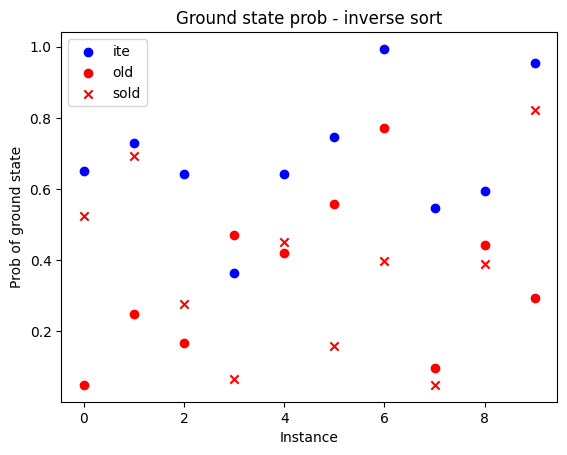

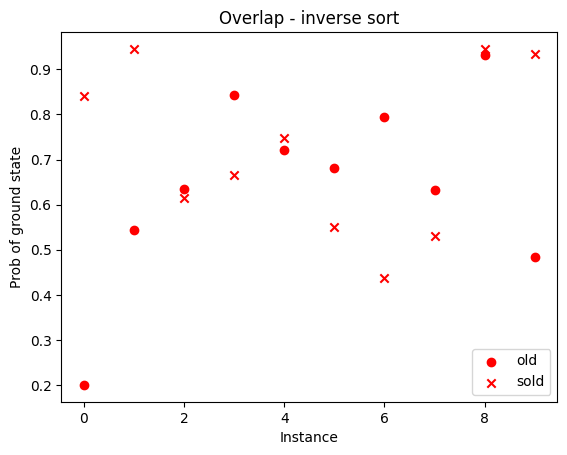

In [59]:
# NEW COLUMNS  GROUPING FOR SORTING inverse
# Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    # abss = np.abs(coeff_list[N:])
    sorted_index = np.argsort(coeff_list[N:])[::-1]
    # sorted_index = np.argsort(coeff_list[N:])[::-1]
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]

    # print(edge_list)
    print(pairs_all)
    print('sorted_pairs_all', sorted_pairs_all) 


    # #CHANGE HERE!!
    # def find_light_cone(pairs):
    # lightcone_dict = {}
    # for index, list in enumerate(pairs):
    #     for pair in list:
    #         qi, qj = pair
    #         relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
    #         if index > 0:
    #             for pair_layerm1 in pairs[index-1]: ## qubit pairs in the previous layer
    #                 if (qi in pair_layerm1) or (qj in pair_layerm1):
    #                     relevent_pairs.append(pair_layerm1)
    #         lightcone_dict[pair] = relevent_pairs
    # return lightcone_dict

# grouped = [[]]

# for t in sorted_pairs_all:
#     added = False
#     qi, qj = t
#     for group in grouped:
#         print('group', group)
#         if any(x in pair for pair in group for x in t):
#             # Check if any value in the tuple is already in the group
#                 group.append(t)
#                 added = True
#                 print(grouped)
#                 break
#     if not added:
#         grouped.append(t)  # Start a new group
#         print(grouped)
# print(grouped)

    grouped = []
    group = []

    for t in sorted_pairs_all:
    #    added = False
        qi, qj = t
        if any(qi in pair for pair in group) or any(qj in pair for pair in group):
            grouped.append(group)
            # added = True
            group = []
        # for group in grouped:
        #     print('group', group)
        #     # if False: # any(x in pair for pair in group for x in t):
        #     #     # Check if any value in the tuple is already in the group
        #     #         group.append(t)
        #     #         added = True
        #     #         print(grouped)
        #     #         break
        # if not added:
        group.append(t)  # Start a new group
    grouped.append(group)

    if len(list(itertools.chain.from_iterable(grouped))) != len(pairs_all):
        sys.stderr.write('something is wrong with the new columns')
        sys.exit()

    print('\n columns', grouped)
    grouped_lightcone_dict = find_light_cone(grouped)
    print('\n lightcone',grouped_lightcone_dict)

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(grouped):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, grouped, eigen_list, grouped_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()




#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
length 15
[ 9  5  1  4  7  6  0 10 11  3  2 12  8 14 13]
[(0, 1),

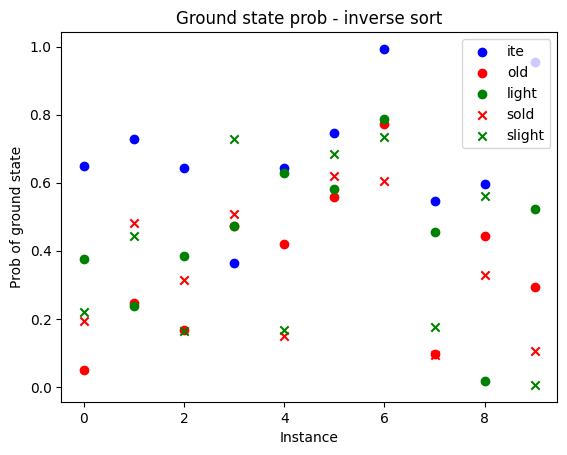

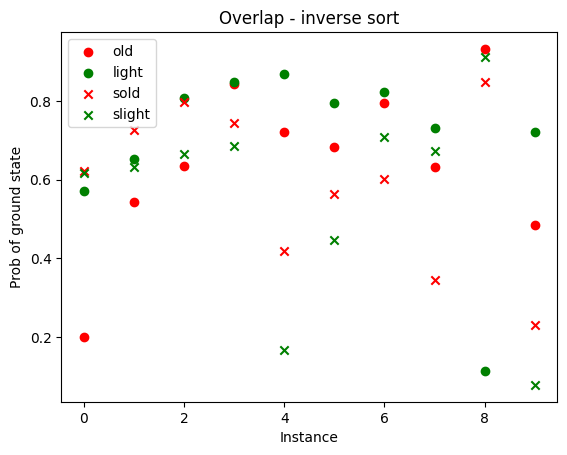

In [44]:
#SORTED
#  Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sorted_index = np.argsort(coeff_list[N:])
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]
    sorted_edge_columns = copy.deepcopy(edges_columns)
    print('length', len(sorted_pairs_all))
    counter = 0
    for id_col, column in enumerate(edges_columns):
        sorted_edge_columns[id_col]= [sorted_pairs_all[x + counter] for x in range(len(column))]
        counter += len(column)

    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

    print(sorted_index)

    # print(edge_list)
    print(pairs_all)
    print(sorted_pairs_all) 
    print("\n")
    print(edges_columns)                                 
    print(lightcone_dict)
    print("\n")
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)


    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
length 15
[13 14  8 12  2  3 11 10  0  6  7  4  1  5  9]
[(0, 1),

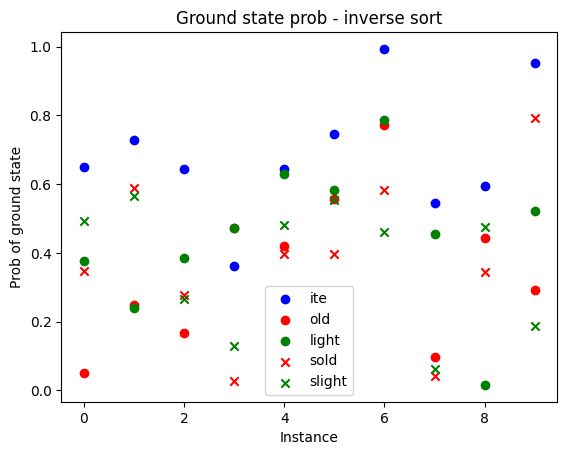

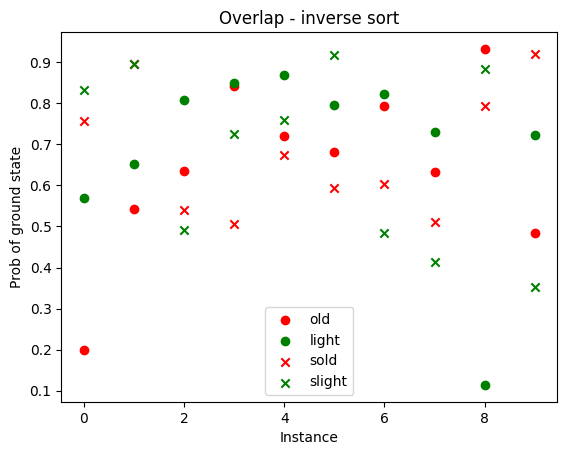

In [45]:
#INVERT SORTED
# # Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sorted_index = np.argsort(coeff_list[N:])[::-1]
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]
    sorted_edge_columns = copy.deepcopy(edges_columns)
    print('length', len(sorted_pairs_all))
    counter = 0
    for id_col, column in enumerate(edges_columns):
        sorted_edge_columns[id_col]= [sorted_pairs_all[x + counter] for x in range(len(column))]
        counter += len(column)

    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

    print(sorted_index)

    # print(edge_list)
    print(pairs_all)
    print(sorted_pairs_all) 
    print("\n")
    print(edges_columns)                                 
    print(lightcone_dict)
    print("\n")
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)


    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
length 15
[11  3  2 10  0  6  7 12  8 14 13  4  1  5  9]
[(0, 1),

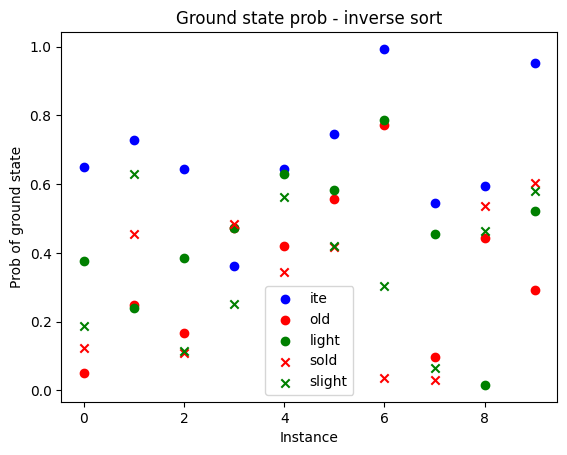

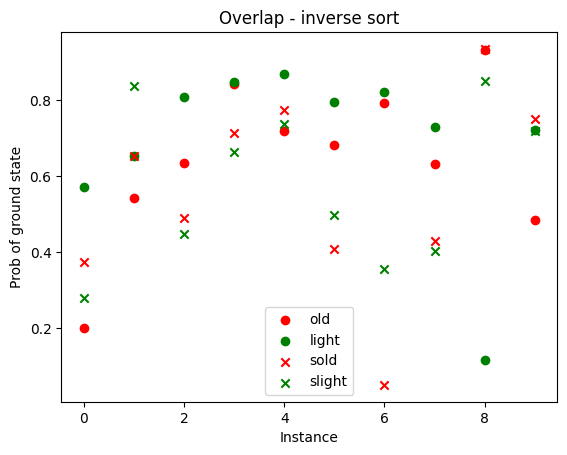

In [46]:
#SORT ABS
#  Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    edge_coeffs_abs = np.abs(coeff_list)
    sorted_index = np.argsort(edge_coeffs_abs[N:])
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]
    sorted_edge_columns = copy.deepcopy(edges_columns)
    print('length', len(sorted_pairs_all))
    counter = 0
    for id_col, column in enumerate(edges_columns):
        sorted_edge_columns[id_col]= [sorted_pairs_all[x + counter] for x in range(len(column))]
        counter += len(column)

    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

    print(sorted_index)

    # print(edge_list)
    print(pairs_all)
    print(sorted_pairs_all) 
    print("\n")
    print(edges_columns)                                 
    print(lightcone_dict)
    print("\n")
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)


    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()



#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
length 15
[ 9  5  1  4 13 14  8 12  7  6  0 10  2  3 11]
[(0, 1),

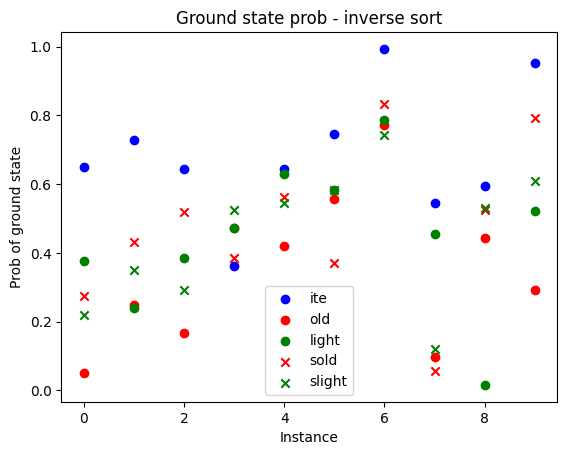

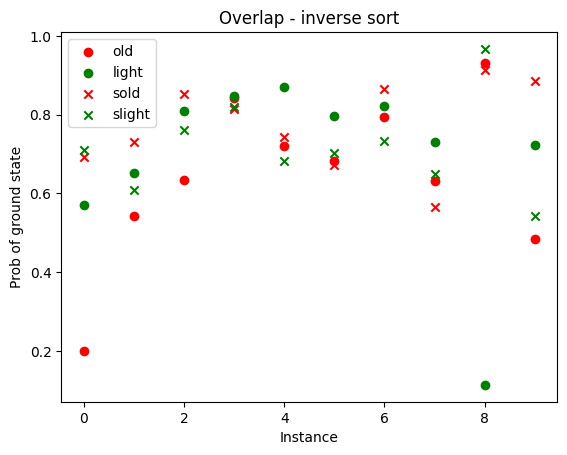

In [47]:
#INVERTED SORT ABS
#  Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    edge_coeffs_abs = np.abs(coeff_list)
    sorted_index = np.argsort(edge_coeffs_abs[N:])[::-1]
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]
    sorted_edge_columns = copy.deepcopy(edges_columns)
    print('length', len(sorted_pairs_all))
    counter = 0
    for id_col, column in enumerate(edges_columns):
        sorted_edge_columns[id_col]= [sorted_pairs_all[x + counter] for x in range(len(column))]
        counter += len(column)

    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

    print(sorted_index)

    # print(edge_list)
    print(pairs_all)
    print(sorted_pairs_all) 
    print("\n")
    print(edges_columns)                                 
    print(lightcone_dict)
    print("\n")
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)


    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()



#############################################################################
tau: 0.7
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
length 15
[ 9  5  1  4  7  6  0 10 11  3  2 12  8 14 13]
[(0, 1

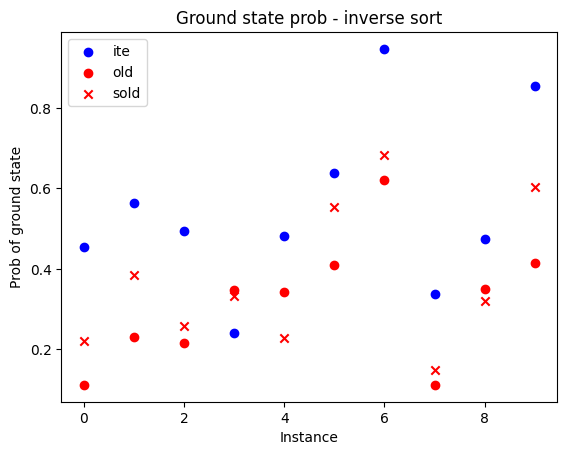

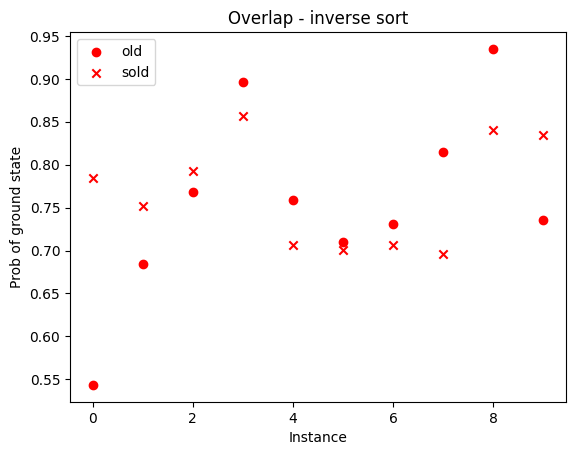

In [48]:
#INVERT SORTED
# # Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 0.7
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    # ABSAR = np.abs(coeff_list[N:])
    # sorted_index = np.argsort(ABSAR)[::-1]
    sorted_index = np.argsort(coeff_list[N:])
    sorted_pairs_all = [pairs_all[x] for x in sorted_index]
    sorted_edge_columns = copy.deepcopy(edges_columns)
    print('length', len(sorted_pairs_all))
    counter = 0
    for id_col, column in enumerate(edges_columns):
        sorted_edge_columns[id_col]= [sorted_pairs_all[x + counter] for x in range(len(column))]
        counter += len(column)

    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)

    print(sorted_index)

    # print(edge_list)
    print(pairs_all)
    print(sorted_pairs_all) 
    print("\n")
    print(edges_columns)                                 
    print(lightcone_dict)
    print("\n")
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)


    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
# plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
# plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.25270118372

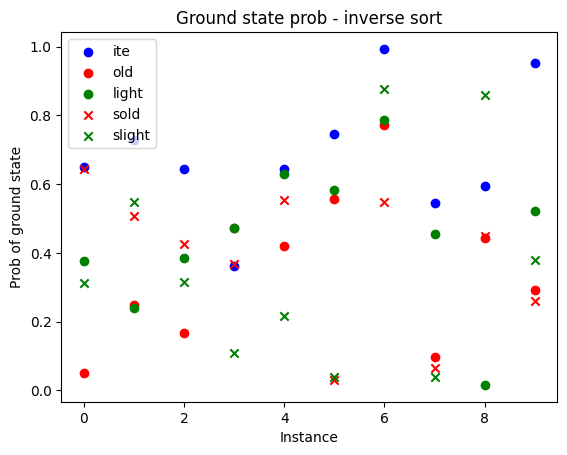

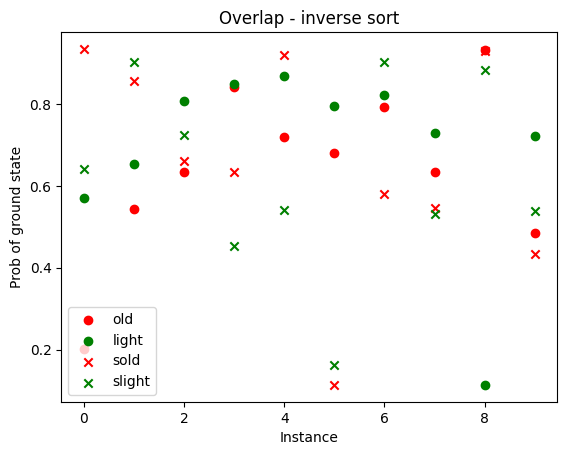

In [24]:
#SORT ONLY THE COLUMNS inverted
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sum_jcol = []
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        sum_jcol.append(sum_j)
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    print('\n sum', sum_jcol)
    new_index = np.argsort(sum_jcol)[::-1]
    print(new_index)

    print(np.array(edges_columns,  dtype=object).shape)
    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
# plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()



In [155]:
def sorted_columns(edges_columns, Abs, invert):
    sum_jcol = []

    if Abs:
        for column in edges_columns:
            abs_sum_j = 0
            for edge in column:
                abs_sum_j += abs(edge_coeff_dict[edge])
            sum_jcol.append(abs_sum_j)

    else:
        for column in edges_columns:
            sum_j = 0 
            for edge in column:
                sum_j += edge_coeff_dict[edge]
            sum_jcol.append(sum_j)

    new_index = np.argsort(sum_jcol)
    
    if invert:
        new_index = new_index[::-1]

    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    return sorted_edge_columns.tolist()

In [162]:
sorted_edge_columns = sorted_columns(edges_columns, False, True)
sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
print(edges_columns)
print(sorted_edge_columns)


sum_jcol = []
# Print lists with different colors based on the condition
for column_index, column in enumerate(edges_columns):
    toprint = []
    sum_j = 0 
    abs_sum_j = 0
    for edge in column:
        toprint.append(edge_coeff_dict[edge])  
        sum_j += edge_coeff_dict[edge]
        abs_sum_j += abs(edge_coeff_dict[edge])
    sum_jcol.append(sum_j)
    print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)


# Print lists with different colors based on the condition
print("\n SORTED \n")
for column_index, column in enumerate(sorted_edge_columns):
    toprint = []
    sum_j = 0 
    abs_sum_j = 0
    for edge in column:
        toprint.append(edge_coeff_dict[edge])  
        sum_j += edge_coeff_dict[edge]
        abs_sum_j += abs(edge_coeff_dict[edge])
    print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)


[[(0, 1), (2, 3), (4, 5)], [(0, 3), (2, 5)], [(1, 3), (0, 5), (2, 4)], [(1, 5), (0, 4)], [(3, 5), (1, 4), (0, 2)], [(3, 4), (1, 2)]]
[[(3, 4), (1, 2)], [(3, 5), (1, 4), (0, 2)], [(1, 5), (0, 4)], [(0, 3), (2, 5)], [(0, 1), (2, 3), (4, 5)], [(1, 3), (0, 5), (2, 4)]]
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.2527011837235027] -0.9071862017125254 1.4125885691595308 
 col:  1 [0.19732171979425606, -0.8155654977945004] -0.6182437780002443 1.0128872175887564 
 col:  2 [-0.8862968972413452, -0.5257356005437253, -0.5291926592236746] -1.941225157008745 1.941225157008745 
 col:  3 [0.5487427641378577, -0.9147977378703538] -0.36605497373249607 1.4635405020082115 
 col:  4 [-0.29060944204302297, -0.06166679275725784, 0.5351598390152261] 0.18288360421494532 0.8874360738155069 
 col:  5 [0.7270332756282649, 0.555240952676433] 1.282274228304698 1.282274228304698 

 SORTED 

 col:  0 [0.7270332756282649, 0.555240952676433] 1.282274228304698 1.282274228304698 
 col:  1 [-0.29060944204302297



#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.25270118372

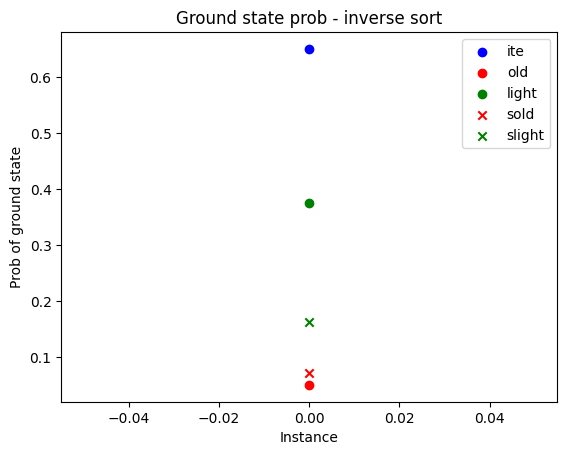

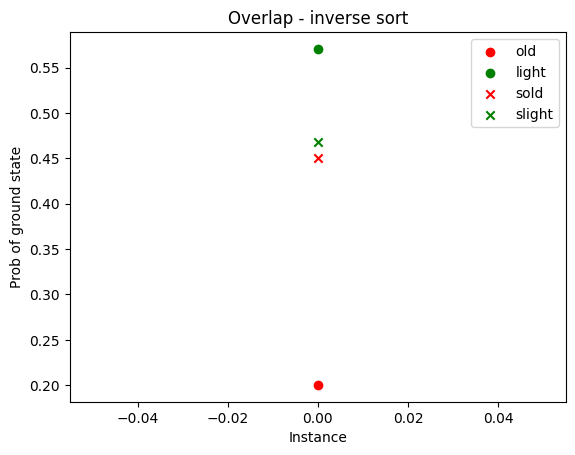

In [130]:
#SORT ONLY THE COLUMNS 
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 1

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sum_jcol = []
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        sum_jcol.append(sum_j)
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    print('\n sum', sum_jcol)
    new_index = np.argsort(sum_jcol)
    print(new_index)

    print(np.array(edges_columns,  dtype=object).shape)
    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)


# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.25270118372

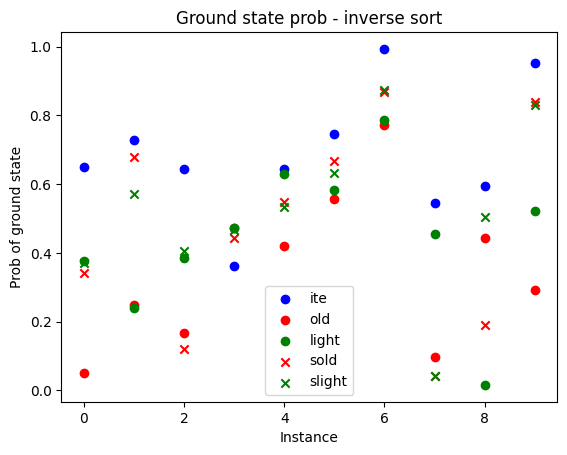

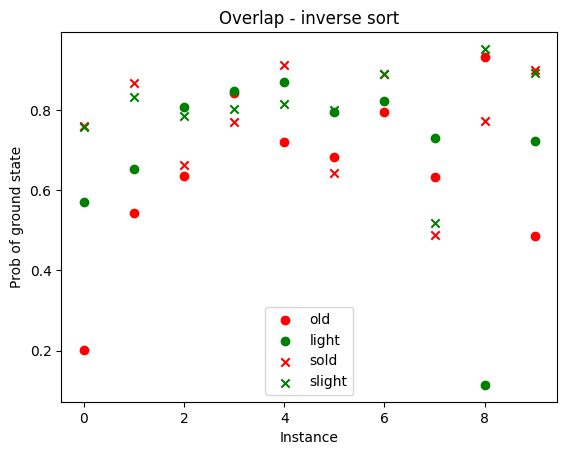

In [28]:
#SORT ONLY THE COLUMNS abs sort
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sum_jcol = []
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        sum_jcol.append(sum_j)
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    print('\n sum', sum_jcol)
    sum_jcol = np.abs(sum_jcol)
    new_index = np.argsort(sum_jcol)
    print(new_index)

    print(np.array(edges_columns,  dtype=object).shape)
    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.25270118372

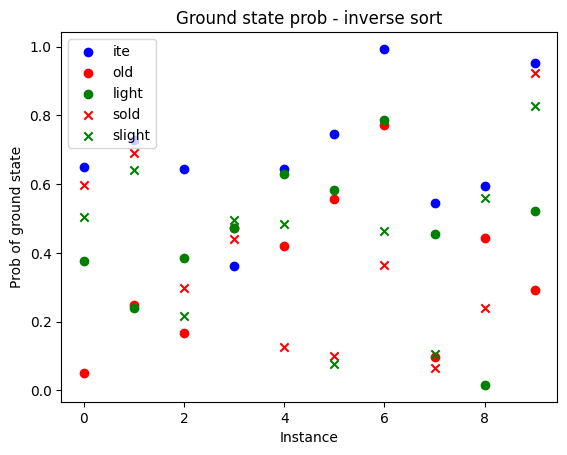

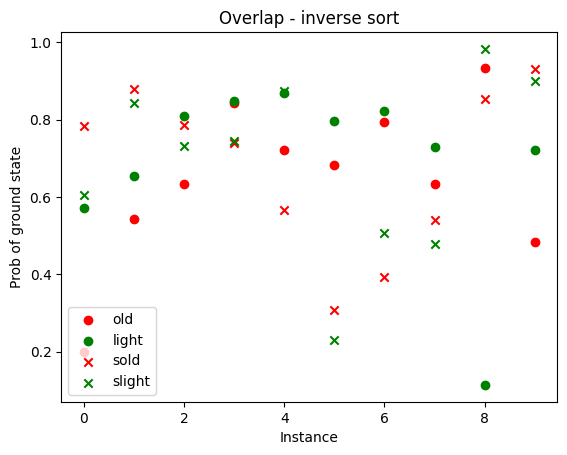

In [29]:
#SORT ONLY THE COLUMNS abs value sort
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sum_jcol = []
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        sum_jcol.append(abs_sum_j)
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    print('\n sum', sum_jcol)
    new_index = np.argsort(sum_jcol)
    print(new_index)

    print(np.array(edges_columns,  dtype=object).shape)
    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.25270118372

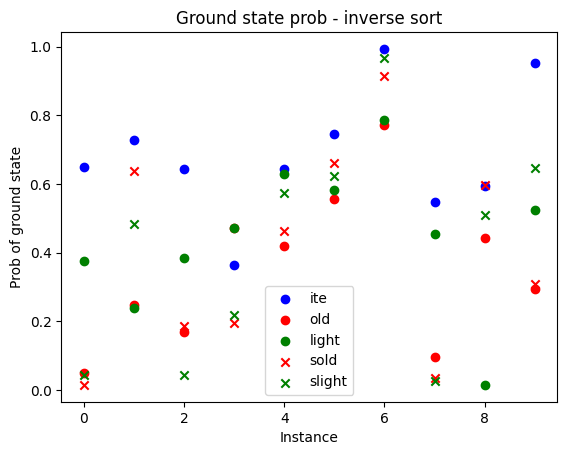

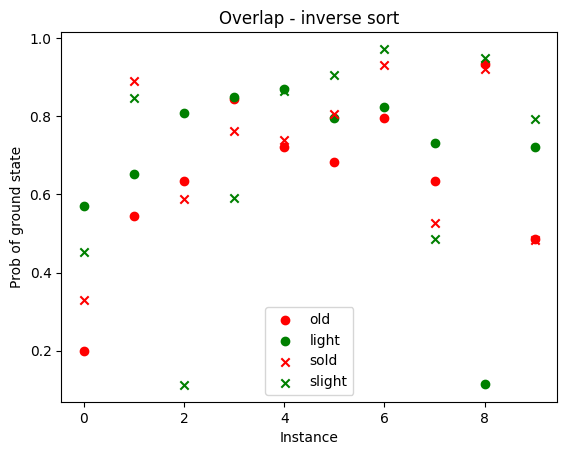

In [30]:
#SORT ONLY THE COLUMNS abs value inverse sort
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sum_jcol = []
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        sum_jcol.append(abs_sum_j)
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    print('\n sum', sum_jcol)
    new_index = np.argsort(sum_jcol)[::-1]
    print(new_index)

    print(np.array(edges_columns,  dtype=object).shape)
    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)

print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()





#############################################################################
tau: 1
[-0.36870817 -0.09393865 -0.46603547 -0.78214364  0.73633296  0.25945704
 -0.29496258 -0.8649248   0.25270118  0.19732172 -0.8155655  -0.8862969
 -0.5257356  -0.52919266  0.54874276 -0.91479774 -0.29060944 -0.06166679
  0.53515984  0.72703328  0.55524095]
{(0,): -0.3687081708224118, (1,): -0.09393864630821547, (2,): -0.4660354722200759, (3,): -0.7821436359263276, (4,): 0.736332958570757, (5,): 0.2594570356539647, (0, 1): -0.2949625841653698, (2, 3): -0.8649248012706583, (4, 5): 0.2527011837235027, (0, 3): 0.19732171979425606, (2, 5): -0.8155654977945004, (1, 3): -0.8862968972413452, (0, 5): -0.5257356005437253, (2, 4): -0.5291926592236746, (1, 5): 0.5487427641378577, (0, 4): -0.9147977378703538, (3, 5): -0.29060944204302297, (1, 4): -0.06166679275725784, (0, 2): 0.5351598390152261, (3, 4): 0.7270332756282649, (1, 2): 0.555240952676433}
 col:  0 [-0.2949625841653698, -0.8649248012706583, 0.25270118372

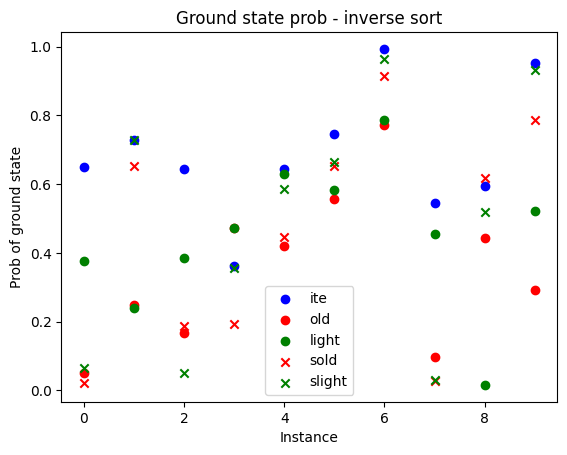

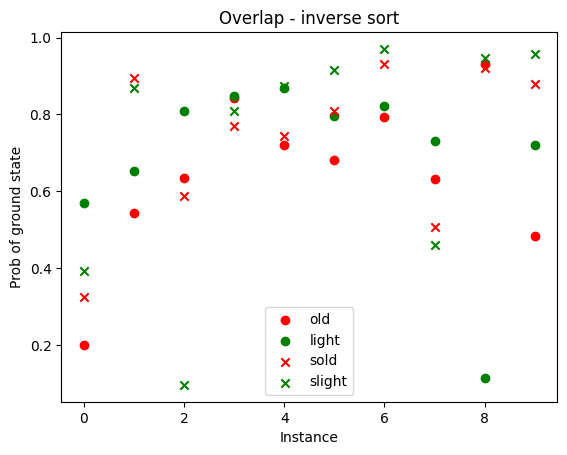

In [31]:
#SORT ONLY THE COLUMNS abs value sort middle
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')
print('tau:', tau)

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []

soldp = []
soldov = []
slightp = []
slightov = []
sadapp = []
sadapov = []
 

for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    print(coeff_list)
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    sum_jcol = []
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        sum_jcol.append(abs_sum_j)
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    print('\n sum', sum_jcol)


    new_index = np.argsort(sum_jcol)[::-1]

    # Step 2: Find the middle index
    mid = len(sum_jcol) // 2
    
    # Step 3: Split into two parts
    first_half = new_index[:mid]
    second_half = new_index[mid:]
    
    # Step 4: Reverse the second half
    second_half = second_half[::-1]

    new_index = np.concatenate((first_half, second_half))
    print(new_index)

    print(np.array(edges_columns,  dtype=object).shape)
    sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    print(sorted_edge_columns)
    print(sorted_lightcone_dict)

    # Print lists with different colors based on the condition
    print("\n SORTED \n")
    for column_index, column in enumerate(sorted_edge_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    soldp.append(list(exp_poss_dict.items())[0][1])
    soldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # sadapp.append(list(exp_poss_dict.items())[0][1])
    # sadapov.append(abs(np.dot(state_ite, state_all))**2)


print("\n ##########################################\n")
# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(oldp, soldp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 OLD WAY: {count_larger}")
print("Before i was better for: ", count_list)

# Reset count
count_larger = 0
count_list = []

# Loop through both lists at the same time using zip
for i, (val1, val2) in enumerate(zip(lightp, slightp)):
    if val1 > val2:
        print(f"Index {i}: list1 = {val1}, list2 = {val2}")
        count_larger += 1
        count_list.append(i)
# Print the total count
print(f"Number of values where list1 > list2 LIGHTCONE: {count_larger}")
print("Before i was better for: ", count_list)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), itep, label='ite', marker='o', color='blue')
plt.scatter(range(ntrials), oldp, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightp, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapp, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldp, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightp, label='slight', marker='x', color='green')
# plt.scatter(range(ntrials), sadapp, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter(range(ntrials), oldov, label='old', marker='o', color='red')
plt.scatter(range(ntrials), lightov, label='light', marker='o', color='green')
#plt.scatter(range(ntrials), adapov, label='adap', marker='o', color='orange')
plt.scatter(range(ntrials), soldov, label='sold', marker='x', color='red')
plt.scatter(range(ntrials), slightov, label='slight', marker='x', color='green')
#plt.scatter(range(ntrials), sadapov, label='sadap', marker='x', color='orange')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()


# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# # plt.scatter( range(ntrials), oldp, label='old', marker='x')
# # plt.scatter( range(ntrials), lightp, label='light', marker='x')
# # plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("JSum - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("jsum")
# plt.legend()



In [32]:
print(edge_coeff_dict)

print(edge_coeff_dict.values())
print(np.sort(list(edge_coeff_dict.values())))

{(0,): -0.08287138936875893, (1,): 0.5739751371736495, (2,): -0.9254607820041656, (3,): -0.7834828359378698, (4,): -0.4167359333667946, (5,): 0.7058161386847681, (0, 1): 0.3669662546714121, (2, 3): -0.9758691014444636, (4, 5): 0.5514626115420143, (0, 3): 0.6297006732423451, (2, 5): 0.9176031290691262, (1, 3): 0.8887721238575734, (0, 5): 0.497449174347774, (2, 4): 0.7697127373026538, (1, 5): -0.43425453756352894, (0, 4): 0.9844801585118907, (3, 5): 0.19841177145292765, (1, 4): -0.5433331596441977, (0, 2): 0.60753776012668, (3, 4): -0.907361758667693, (1, 2): 0.25356279819415417}
dict_values([-0.08287138936875893, 0.5739751371736495, -0.9254607820041656, -0.7834828359378698, -0.4167359333667946, 0.7058161386847681, 0.3669662546714121, -0.9758691014444636, 0.5514626115420143, 0.6297006732423451, 0.9176031290691262, 0.8887721238575734, 0.497449174347774, 0.7697127373026538, -0.43425453756352894, 0.9844801585118907, 0.19841177145292765, -0.5433331596441977, 0.60753776012668, -0.907361758667

In [33]:
coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )

h_list = coeff_list[: N ]
J_list = coeff_list[N :]

pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list

#CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

for key in edge_coeff_dict.keys():
    print(f"{key}: {edge_coeff_dict[key]}")

sorted_keys = sorted(edge_coeff_dict, key=edge_coeff_dict.get)
print('\nsorted')
for key in sorted_keys:
    print(f"{key}: {edge_coeff_dict[key]}")

edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})

(0, 1): -0.5781649986853428
(2, 3): 0.8121874395187261
(4, 5): 0.8998026136881476
(0, 3): 0.7943631580162374
(2, 5): -0.045329837987815313
(1, 3): 0.4629661502177109
(0, 5): -0.813452261795115
(2, 4): -0.11960960627399642
(1, 5): -0.6969097379740585
(0, 4): -0.7901676758444729
(3, 5): 0.1922411466082743
(1, 4): -0.002903762392375109
(0, 2): 0.32812564086210494
(3, 4): -0.5208193706403483
(1, 2): -0.5665670367756495

sorted
(0, 5): -0.813452261795115
(0, 4): -0.7901676758444729
(1, 5): -0.6969097379740585
(0, 1): -0.5781649986853428
(1, 2): -0.5665670367756495
(3, 4): -0.5208193706403483
(2, 4): -0.11960960627399642
(2, 5): -0.045329837987815313
(1, 4): -0.002903762392375109
(3, 5): 0.1922411466082743
(0, 2): 0.32812564086210494
(1, 3): 0.4629661502177109
(0, 3): 0.7943631580162374
(2, 3): 0.8121874395187261
(4, 5): 0.8998026136881476


In [34]:
grouped = []
group = []

for t in sorted_keys:
    added = False
    qi, qj = t
    if any(qi in pair for pair in grouped) or any(qj in pair for pair in group for group in grouped):
        grouped.append(group)
        added = True
        group = []
    # for group in grouped:
    #     print('group', group)
    #     # if False: # any(x in pair for pair in group for x in t):
    #     #     # Check if any value in the tuple is already in the group
    #     #         group.append(t)
    #     #         added = True
    #     #         print(grouped)
    #     #         break
    # if not added:
    group.append(t)  # Start a new group

print('\n columns', grouped)
grouped_lightcone_dict = find_light_cone(grouped)
print('\n lightcone',grouped_lightcone_dict)


 columns []

 lightcone {}


In [35]:
N = 6  # Example length of the outer list

# Step 1: Initialize a nested list with N empty sublists
nested_list = [[] for _ in range(N)]

# Step 2: Fill the nested list iteratively
# Assume you have some logic or data to fill in
for t in sorted_keys:
    added = False
    qi, qj = t
    print(nested_list)
    print(qi,qj)
    for i in range(N):
        # Example: Append some values to each sublist based on the index
        # The number of items in each sublist is not known initially
        if any(qi in pair for pair in nested_list[i]) or any(qj in pair for pair in nested_list[i]):  # Adding i + 1 elements to the i-th sublist as an example
            continue
        else:
            nested_list[i].append(t)
            break


[[], [], [], [], [], []]
0 5
[[(0, 5)], [], [], [], [], []]
0 4
[[(0, 5)], [(0, 4)], [], [], [], []]
1 5
[[(0, 5)], [(0, 4), (1, 5)], [], [], [], []]
0 1
[[(0, 5)], [(0, 4), (1, 5)], [(0, 1)], [], [], []]
1 2
[[(0, 5), (1, 2)], [(0, 4), (1, 5)], [(0, 1)], [], [], []]
3 4
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1)], [], [], []]
2 4
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4)], [], [], []]
2 5
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4)], [(2, 5)], [], []]
1 4
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4)], [(2, 5), (1, 4)], [], []]
3 5
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4), (3, 5)], [(2, 5), (1, 4)], [], []]
0 2
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4), (3, 5)], [(2, 5), (1, 4)], [(0, 2)], []]
1 3
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4), (3, 5)], [(2, 5), (1, 4)], [(0, 2), (1, 3)], []]
0 3
[[(0, 5), (1, 2), (3, 4)], [(0, 4), (1, 5)], [(0, 1), (2, 4), (3, 5)], [(2, 5

In [36]:
for column in nested_list:
    for edge in column:
        print(edge, edge_coeff_dict[edge])

(0, 5) -0.813452261795115
(1, 2) -0.5665670367756495
(3, 4) -0.5208193706403483
(0, 4) -0.7901676758444729
(1, 5) -0.6969097379740585
(2, 3) 0.8121874395187261
(0, 1) -0.5781649986853428
(2, 4) -0.11960960627399642
(3, 5) 0.1922411466082743
(2, 5) -0.045329837987815313
(1, 4) -0.002903762392375109
(0, 3) 0.7943631580162374
(0, 2) 0.32812564086210494
(1, 3) 0.4629661502177109
(4, 5) 0.8998026136881476


In [37]:
for i in range(N):
    print(edge_coeff_dict[(i,)])

0.9661454354812704
-0.2746437235199801
0.2176752986976731
0.5282527905126817
0.019805365672016073
0.8718772518292106


In [38]:
print(partition_N(N))

[[(0, 1), (2, 3), (4, 5)], [(0, 3), (2, 5)], [(1, 3), (0, 5), (2, 4)], [(1, 5), (0, 4)], [(3, 5), (1, 4), (0, 2)], [(3, 4), (1, 2)]]


In [39]:
coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
h_list = coeff_list[: N ]
J_list = coeff_list[N :]

# h_list = [1,1,1,1,-1,-1]
# J_list = np.zeros(len(G.edges()) ) + 1

edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
edge_list = G.edges()

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list

#CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real

print(np.argmin(eigen_list))
print(np.sort(eigen_list)[:10])
print(len(eigen_list))
# print(bin(np.argmin(eigen_list))[2:])
print(f'{np.argmin(eigen_list):06b}')

eigen_sorted = np.sort(eigen_list)
print('spectral gap', eigen_sorted[1]- eigen_sorted[0])

27
[-6.53276995 -4.92402627 -4.60082839 -4.14663128 -3.97073653 -3.74057364
 -3.7027176  -3.49718106 -3.09696115 -3.06608018]
64
011011
spectral gap 1.608743682661549


In [40]:
for edge, value in edge_coeff_dict.items():
    if value < 0 :
        print(edge, value)

(0,) -0.7165275724236106
(1,) -0.08698855130103866
(2,) -0.8217796922117582
(5,) -0.3216451125257822
(0, 1) -0.8075246263184541
(0, 3) -0.018498868838930704
(1, 3) -0.06879074943190666
(0, 4) -0.07500289568595342
(1, 4) -0.961820069055229
(0, 2) -0.016096820812764978


In [41]:
for edge, value in edge_coeff_dict.items():
    if value > 0 :
        print(edge, value)

(3,) 0.33518118691201537
(4,) 0.6059268407179772
(2, 3) 0.6567271529925485
(4, 5) 0.0266717931526812
(2, 5) 0.1928864886903039
(0, 5) 0.797568783496236
(2, 4) 0.6225102479609428
(1, 5) 0.8574244160705207
(3, 5) 0.21484132502485576
(3, 4) 0.4896674418694835
(1, 2) 0.8430230649414621


In [42]:
#SORT ONLY THE COLUMNS inverted  - many
#   Set the seed
# np.random.seed(42)
np.random.seed(420)

N = 6
tau = 1
Numpara = 2

ntrials = 10

G = nx.complete_graph(N)
print('\n\n#############################################################################')



for trial in range(ntrials):
    coeff_list = np.random.uniform(-1, 1, N + len(G.edges()) )
    # print(coeff_list)
    coeff_list = np.sort(coeff_list)[::-1]
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]


    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    edge_list = G.edges()


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})
    # print(edge_coeff_dict)

    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real

    # print(np.argmin(eigen_list))
    print(np.sort(eigen_list)[:10])
    # print(len(eigen_list))
    # # print(bin(np.argmin(eigen_list))[2:])
    # print(f'{np.argmin(eigen_list):06b}')

    eigen_sorted = np.sort(eigen_list)
    print('\nspectral gap', eigen_sorted[1]- eigen_sorted[0]) 

    # sum_jcol = []
    # # Print lists with different colors based on the condition
    # for column_index, column in enumerate(edges_columns):
    #     toprint = []
    #     sum_j = 0 
    #     abs_sum_j = 0
    #     for edge in column:
    #         toprint.append(edge_coeff_dict[edge])  
    #         sum_j += edge_coeff_dict[edge]
    #         abs_sum_j += abs(edge_coeff_dict[edge])
    #     sum_jcol.append(abs_sum_j)
    #     print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    # print('\n sum', sum_jcol)
    # new_index = np.argsort(sum_jcol)[::-1]
    # print(new_index)

    # print(np.array(edges_columns,  dtype=object).shape)
    # sorted_edge_columns = copy.deepcopy(np.array(edges_columns,  dtype=object)[new_index]) 
    # sorted_lightcone_dict = find_light_cone(sorted_edge_columns)
    # print(sorted_edge_columns)
    # print(sorted_lightcone_dict)

    # # Print lists with different colors based on the condition
    # print("\n SORTED \n")
    # for column_index, column in enumerate(sorted_edge_columns):
    #     toprint = []
    #     sum_j = 0 
    #     abs_sum_j = 0
    #     for edge in column:
    #         toprint.append(edge_coeff_dict[edge])  
    #         sum_j += edge_coeff_dict[edge]
    #         abs_sum_j += abs(edge_coeff_dict[edge])
    #     print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all, r = warm_start_parameters_lightcone2(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    print('r', r)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)
    edge_params_dict, params_init, exp_poss_dict, state_all, r = warm_start_parameters_lightcone2(N, tau, edge_coeff_dict, sorted_edge_columns, eigen_list, sorted_lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    slightp.append(list(exp_poss_dict.items())[0][1])
    slightov.append(abs(np.dot(state_ite, state_all))**2)
    print('r', r)




#############################################################################
[-9.80652186 -5.2298805  -5.12572976 -4.98899624 -4.01794849 -3.75573484
 -3.54092943 -3.21868754 -3.08258821 -2.79685559]

spectral gap 4.576641355493422

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-9.806521860351685, 0.9997194795462607)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone


NameError: name 'warm_start_parameters_lightcone2' is not defined

In [213]:
def warm_start_parameters_lightcone2(N : int, tau:float, edge_coeff_dict : dict, edges_columns :list,  eigen_list:list, lightcone_dict: dict):    

    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
    
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    # Z term
    for i in range(N):

        #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)
        
    ## ZZ term 
    state = Statevector(circ)
    #updated_state = state 
    #updated_state = copy.deepcopy(state)

    # print('state in', state)
    #print('updated_state in', updated_state)

    #print('\nnumber of columns is:', len(edges_columns))

    for column_index, column in enumerate(edges_columns):
        # print('\n##################################################')
        # print('column index', column_index, 'column', column)

        if column_index == 0: 

            first_column_state = state
            #first_column_state = copy.deepcopy(state)

            for edge in column:
                
                if len(lightcone_dict[edge]) != 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()
            
                # print('\nedge', edge)  

                tauc = tau * edge_coeff_dict[edge]

                para_init = [0,0]
                # para_init = [pi/2,pi/2]

                final = minimize(square_modulus_cost,
                                    para_init,
                                    args = (edge, first_column_state, tauc, N),
                                    jac=False,
                                    bounds=None,
                                    #method='L-BFGS-B',
                                    method='SLSQP',
                                    callback=None,
                                    options={'maxiter': 1000})

                para = final.x

                # print('opt paramenters', para)
                # print('final square modulus', final.fun)
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                edge_params_dict[edge] = para
                # print('edge_params_dict:', edge_params_dict)

                # print('old state', state)
                first_column_state = circuit_update_theta(edge, first_column_state, para, N)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT

                # print('first column state - new state', first_column_state)
            
        else:
            
            for edge in column: 
                # if len(lightcone_dict[edge]) == 0:
                #         sys.stderr.write('something is wrong with the lightcones')
                #         sys.exit()

                # print('\nedge', edge)  

                # print('len light cone:', len(lightcone_dict[edge]), ', light cone edges:', lightcone_dict[edge])

                # print('initial state', state)

                updated_state = copy.deepcopy(state)
                #updated_state = state

                #print('state in', state, 'column edge', column, edge)
                #print('updated_state in', updated_state, 'column edge', column, edge)
                
                for old_edge in lightcone_dict[edge]:
                    # print('old_edge', old_edge, 'param', edge_params_dict[old_edge])
                    updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N)    
                
                # print('updated_state', updated_state)

                edge_list = lightcone_dict[edge] + [edge]
                # print('edge list', edge_list)
                
                tauc = tau * edge_coeff_dict[edge]

                para_init = np.zeros(2 + 2*len(lightcone_dict[edge]))
                # para_init = np.zeros(2 + 2*len(lightcone_dict[edge])) + pi/2
                # print('para init', para_init)

                final = minimize(square_modulus_cost_light_cone,
                        para_init,
                        args = (edge_list, state, tauc, updated_state, N),
                        jac=False,
                        bounds=None,
                        #method='L-BFGS-B', 
                        method='SLSQP',
                        callback=None,
                        options={'maxiter': 1000})

                para = final.x
                # print('opt paramenters', para)
                # print('final square modulus', final.fun)
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                para = (np.array(para)).reshape(-1, 2)
                # print('param list reshaped', para)
                for index, edge in enumerate(edge_list):
                    edge_params_dict[edge] = para[index] 
                # print('edge_params_dict', edge_params_dict)
            
            # print('\n######### previous column update ########')
            # print('column index', column_index, 'column', column)
            # print('previous column is:', edges_columns[column_index -1])

            for edge in edges_columns[column_index -1]:
                # print('edge', edge, 'parameter', edge_params_dict[edge])
                state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

            # print('circuit updated ad the previous column i.e. column', column_index -1)
            # print('updated statevector', state)

    # print('\n######### last column update ########')
    # print('last column is:', edges_columns[ -1])

    for edge in edges_columns[ -1]:
        # print('edge', edge, 'parameter', edge_params_dict[edge])
        state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

    # print('circuit updated at the last column i.e.', len(edges_columns) - 1)
    #print('updated statevector', state)

    #generate params_list
    values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
    # Concatenate and flatten all arrays into a single array
    flattened_array = np.concatenate(values_as_arrays)
    # Convert the flattened array to a list if needed
    params_list = flattened_array.tolist()
    # print(' params_list' , params_list )

    state = np.array(state)

    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss
    
    r = (final.fun - np.min(eigen_list)) / (np.max(eigen_list) - np.min(eigen_list)) 
        

    # return edge_params_dict, params_list, exp_poss_dict
    return edge_params_dict, params_list, exp_poss_dict, state ,r #Changed to see the state overlap